### HOW TO CONSTRUCT AN ATM CURVE

In [1]:
from datetime import datetime, timedelta, date
from dateutil.relativedelta import *

import ipywidgets as widgets

import calendar

import pandas as pd

import math
import matplotlib.pyplot as plt
import numpy as np

# Generate Tenor Dates
### For the standard tenor dates (O/N up to 2Y) we count from spot date (T+2) until expiry, ignoring weekends. We can import a calendar to include bank holidays in this calculation, but overkill for the purposes of this experiment

In [2]:
# Define the standard tenors
tenors = ['ON', '1W', '2W', '1M', '2M', '3M', '6M', '1Y', '2Y']
expiryDate = []

# Check if provided date is a Friday or Saturday- 
# The next business day will be the following Monday
def nextBusinessDay(day):
    if day.weekday() == 6: # Weekday 6 = Saturday
        return day + timedelta(days=1) # Next business day is 2 days ahead
    elif day.weekday() == 5: # Weekday 5 = Friday
        return day + timedelta(days=2) # Next business day is 3 days ahead
    else:
        return day

# Calculate Spot date (two business days ahead)
def spotDate(day):
    t1 = nextBusinessDay(day)
    t2 = nextBusinessDay(t1)
    return t2

# Calculate the real dates for the standard tenors
for i in range(0, len(tenors)):
    if tenors[i] == 'ON': # Overnight - the next business day
        expiryDate.insert(i, nextBusinessDay(datetime.today() + timedelta(days=1)))
    if 'W' in tenors[i]: # Weeks - 7 * the next business day
        n = int(tenors[i][0])
        expiryDate.insert(i, nextBusinessDay(datetime.today() + timedelta(days=7*n)))
    if 'M' in tenors[i]: # Months
        n = int(tenors[i][0])
        expiryDate.insert(i, nextBusinessDay(spotDate(datetime.today()) + relativedelta(months=+(1*n))))
    if 'Y' in tenors[i]: # Years
        n = int(tenors[i][0])
        expiryDate.insert(i, nextBusinessDay(spotDate(datetime.today()) + relativedelta(years=+(1*n))))

# Output the real tenor dates
for i in range(0, len(expiryDate)):
    print(tenors[i] + ' => ' + datetime.strftime(expiryDate[i], '%a %d-%b-%Y'))


ON => Mon 26-Aug-2024
1W => Mon 02-Sep-2024
2W => Mon 09-Sep-2024
1M => Thu 26-Sep-2024
2M => Mon 28-Oct-2024
3M => Tue 26-Nov-2024
6M => Wed 26-Feb-2025
1Y => Tue 26-Aug-2025
2Y => Wed 26-Aug-2026


# Input ATM implied volatilaties (%)

In [3]:
ivInputs = []
for i in range(0, len(tenors)):
    ivInputs.append(widgets.Text(description=tenors[i]))

for i in ivInputs:
    display(i)

Text(value='', description='ON')

Text(value='', description='1W')

Text(value='', description='2W')

Text(value='', description='1M')

Text(value='', description='2M')

Text(value='', description='3M')

Text(value='', description='6M')

Text(value='', description='1Y')

Text(value='', description='2Y')

# Interpolate ATM Vols
##  Use trader's vols to interpolate and provide a vol quote for any date within the standard tenors.
## We find the closest already-known volatilities behind and ahead of the requested expiry date, and the perform standard linear interpolation between these dates to produce a quote

In [4]:
expiry_over = 0
expiry_under = 0
volSurface = {}
horizon = datetime.today()
# Get known vols from the input fields above
impliedVols = [x.value for x in ivInputs]

# Create a vol surface dictionary, mapping known tenors and their vols
for i in range(0, len(expiryDate)):
    volSurface.update({expiryDate[i]: int(impliedVols[i])})

# Return a vol for any date (expiry) within the tenors
def getATMVol(expiry):
    # Initialise some variables to determine max distance from the requested expiry date
    delta_over = 1000000
    delta_under = 100000
    # Iterate through the already-known expiry dates
    for i in range(0, len(expiryDate)):
        current_tenor = expiryDate[i]
        current_delta = abs(expiryDate[i] - expiry)
        # find nearest marked tenor below expiry
        if current_tenor < expiry:
            if current_delta.days < delta_under:
                delta_under = current_delta.days
                expiry_under = current_tenor
        # find nearest marked tenor above given expiry
        if current_tenor > expiry:
            if current_delta.days < delta_over:
                delta_over = current_delta.days
                expiry_over = current_tenor
    # Convert the neighbouring dates into Days from Horizon to perform interpolation
    delta_expiry = horizon - expiry
    delta_expiry_under = horizon - expiry_under
    delta_expiry_over = horizon - expiry_over

    # Run interpolation function
    return interpolate(volSurface[expiry_under], volSurface[expiry_over], delta_expiry_under.days, delta_expiry_over.days, delta_expiry.days)


# Standard linear interpolation based on two known points in a cartesian plane
# And a known x value, to determine an unknown y value.
def interpolate(y0, y1, x0, x1, x):
    y = (y0*(x1-x) + y1*(x-x0))/(x1-x0)
    return y

# Test the interpolation with an expiry date below:

In [5]:
dp = widgets.DatePicker(description='Expiry Date')
display(dp)


DatePicker(value=None, description='Expiry Date', step=1)

In [6]:
dt = datetime.combine(dp.value, datetime.min.time())

getATMVol(dt)

16.81767955801105

## ATM Curve - Vol entry approach
#### This curve simply plots the entered implied volatilities for the standard tenor dates
#### It allows us to visualise how the volatility quotes are obtained when requesting expiry dates between tenors

/tmp/ipykernel_1559606/1512681483.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tenors)


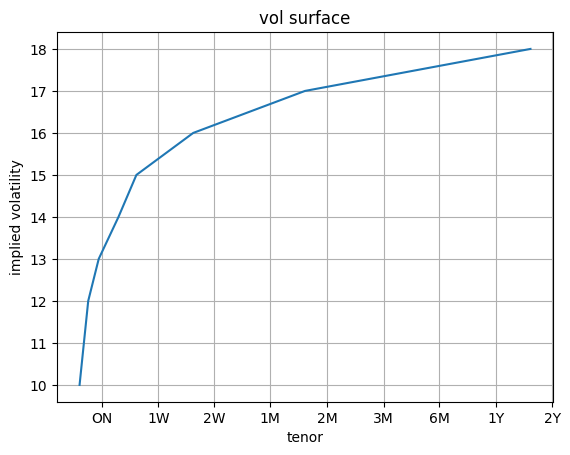

In [7]:
fig, ax = plt.subplots()
impliedVols = [x.value for x in ivInputs]

ax.plot(expiryDate, impliedVols)

ax.set(xlabel='tenor', ylabel='implied volatility',
       title='vol surface')

ax.set_xticklabels(tenors)
ax.grid()


# Variance Profile
#### Using the already-known volatility quotes for the standard tenors, we can calculate the variances between horizon (today) and expiry dates (tenors) to visualise the forward variance. 

#### We expect the variance to increase into the future, as volatility increases steadily based on the traders' inputs from previously

/tmp/ipykernel_1559606/3804269919.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(tenors)


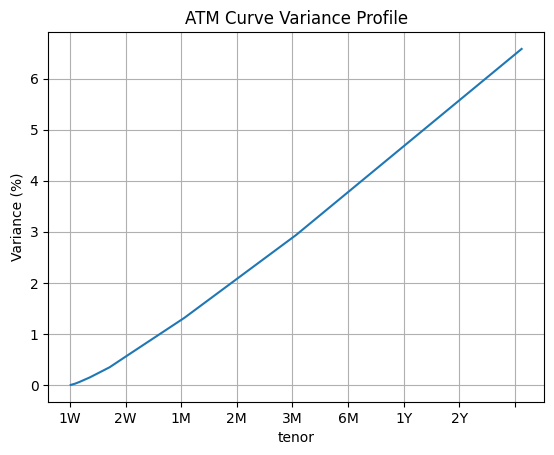

In [9]:
variances = []
times = []
horizon = datetime.today()

def variance(vol, t):
    # Basic variance calculation: v = 𝜎^2 * t
    # Variance = vol ^2 * time to expiry
    return (vol**2) * t

# Variance calculation for entered each date in the vol surface
for key, value in volSurface.items():
    # Time to expiry calculation - number of days between horizon and tenor
    tte = (key - horizon).days
    # Variance calculation - taking the volatility value (sigma) and time to expiry
    v = variance(value, tte/360)
    times.append(tte/360)
    # Divide by 100 to produce a percentage
    variances.append(float(v/100))


# Plot forward variance profile
fig2, ax2 = plt.subplots()
ax2.plot(times, variances)

ax2.set(xlabel='tenor', ylabel='Variance (%)',
       title='ATM Curve Variance Profile')

ax2.set_xticklabels(tenors)

ax2.grid()
plt.show()


# ATM Curve - Model approach
#### Instead of a vol-first approach, we can use models to build the curve, and manipulate the vol surface using weights entered by the trader to identify expiries of hightened volatility (e.g. NFP, FMOC, election dates)

#### One such model is: &sigma;<sub>T</sub> = &sigma;<sub>short</sub> + (&sigma;<sub>long</sub> − &sigma;<sub>short</sub>).(1 − e<sup>−&lambda;T</sup>)

##### Where:
##### &sigma;<sub>T</sub> = ATM Implied vol at time T
##### &sigma;<sub>short</sub>,  &sigma;<sub>long</sub>  = Short and long term ATM vols
##### &lambda; = Speed of reversion from short to long vol.

##### Try it below:

In [10]:
speed = widgets.Text(description='Speed')

shortVol = widgets.FloatSlider(
    value=0,
    min=0,
    max=100.0,
    step=0.5,
    description='Short Vol%:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

longVol = widgets.FloatSlider(
    value=0,
    min=0,
    max=100.0,
    step=0.5,
    description='Long Vol%:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

display(shortVol, longVol, speed)

FloatSlider(value=0.0, continuous_update=False, description='Short Vol%:', readout_format='.1f', step=0.5)

FloatSlider(value=0.0, continuous_update=False, description='Long Vol%:', readout_format='.1f', step=0.5)

Text(value='', description='Speed')

/tmp/ipykernel_1559606/2531999058.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(tenors)


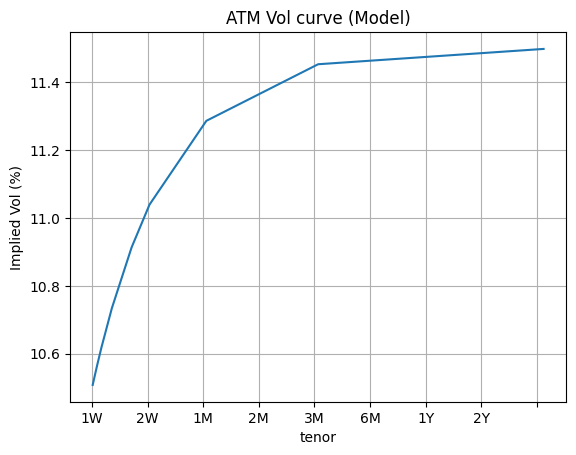

In [18]:
modelVol = []
longVolpct = longVol.value /100
shortVolpct = shortVol.value/100

for i in times:
    vol = shortVolpct + (longVolpct - shortVolpct)*(1-np.exp(-int(speed.value)*i))
    modelVol.append(vol*100)

fig2, ax3 = plt.subplots()
ax3.plot(times, modelVol)


ax3.set(xlabel='tenor', ylabel='Implied Vol (%)',
       title='ATM Vol curve (Model)')

ax3.set_xticklabels(tenors)

ax3.grid()
plt.show()

## Adding weights to the ATM Curve
#### Traders update the ATM curve using weights as discussed above. This model assumes a flat base volatility, but allows the user to manually enter weights, skewing the volatility for that expiry and subsequent dates due to the accumulated variance.

#### ATM curves distinguish between `Calendar Time` (time to expiry for a given contract) and `Economic Time`: the time to expiry with the influence of weightings. Specifically, economic time uses the weighted sum of all the previous dates to calculate a time to expiry.

#### Variance is then calculated using this weighted time to expiry, and volatility is found in the usual way using this variance.


In [19]:
volatility = 10/100 # single flat vol for weighting
dayWeights = {'Sunday': 0.0, 'Monday': 1.0, 'Tuesday': 1.0, 'Wednesday': 1.0, 'Thursday': 1.0, 'Friday': 1.0, 'Saturday': 0.0}

weekWeightInputs = []
for day, weight in dayWeights.items():
    weekWeightInputs.append(widgets.Text(description=day))

for i in weekWeightInputs:
    display(i)


Text(value='', description='Sunday')

Text(value='', description='Monday')

Text(value='', description='Tuesday')

Text(value='', description='Wednesday')

Text(value='', description='Thursday')

Text(value='', description='Friday')

Text(value='', description='Saturday')

In [15]:
dayWeights = {}
for i in weekWeightInputs:
    dayWeights.update({i.description: int(i.value)})

print(dayWeights)

{'Sunday': 0, 'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1, 'Friday': 1, 'Saturday': 0}


##### We notice that the ATM curve is 'sawtoothed' due to the 0-weighted weekends (reduced times of volatility). Each week the vol rises due to the weighted sum of previous vols, and then crashes with the zero weekend weighting

<Axes: xlabel='date'>

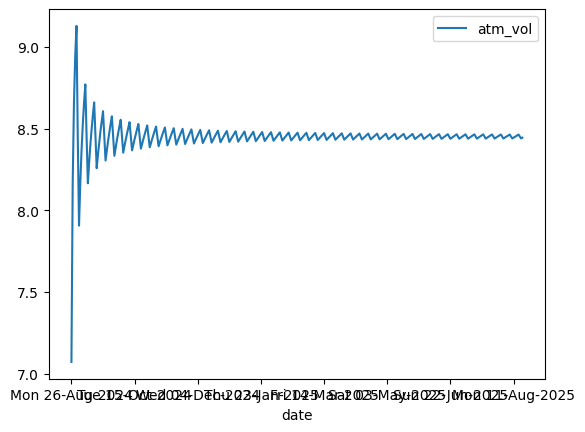

In [23]:
weightedModel = []
horizon = datetime.today()
dayWeightSum = 0

# Calculate vol for the next x days
for i in range(2, 360):
    d = (horizon + timedelta(days=i)) # For each day from the horizon
    caltime = (d-horizon).days/365 # Calendar time => time to expiry (Years)
    dayName = calendar.day_name[d.weekday()] # Get day name to apply weights
    dayWeight = dayWeights[dayName] # Assign weight based on user inputs
    dayWeightSum += dayWeight # Accumulate weights from previous days
    economicTime = dayWeightSum/365 # Economic time uses the weighted day sum (Years)
    totalVariance = economicTime * (volatility**2) # Generate variance as normal
    atmvol = np.sqrt(totalVariance/caltime) # Generate vol as normal
    # Add all of these calculated vars to a dict for easier processing.
    weightedModel.append({'date': d.strftime('%a %d-%b-%Y'), 'calendar_time': caltime, 'day_weight': dayWeight, 'day_weight_sum': dayWeightSum, 'economic_time': economicTime, 'total_variance': totalVariance, 'atm_vol': atmvol*100})

#Convert to dataframe and plot
df = pd.DataFrame(weightedModel)
#df
df.plot(x='date', y='atm_vol')